In [1]:
import sys
# setting path

import copy
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines 
import copy
from argparse import ArgumentParser
import time
import pickle

from Models.Caller64 import *
from Benchmarks.Models.BenchmarkCaller64 import ModelCall as BMCaller
from Benchmarks.Models.DiffWave64 import DiffWAVE_Restoration, determine_gen_steps_diffwave
from Benchmarks.Models.VDiffWave64 import VDiffWAVE_Restoration, determine_gen_steps_vdwave

from Utilities.AncillaryFunctions64 import FFT_PSD, GenConArangeSimple, compute_snr, scale_and_normalize
from Utilities.Utilities import ReadYaml, SerializeObjects, DeserializeObjects, LoadModelConfigs, LoadParams, ReadYaml


from tqdm import trange, tqdm
import itertools
from scipy.stats import mode

import tensorflow as tf
tf.keras.backend.set_floatx('float64')

In [2]:
# =============================================================================
# Helper Functions
# =============================================================================

def compute_kld_divergence(P, Q):
    """
    Compute the symmetric Kullback-Leibler divergence between two PSD distributions.
    
    Parameters:
        P (np.array): PSD of the generated signal.
        Q (np.array): PSD of the reference signal.
    
    Returns:
        np.array: The symmetric KLD value.
    """
    return (np.sum(P * np.log(P / Q), axis=-1) + np.sum(Q * np.log(Q / P), axis=-1)) / 2

def get_frequency_categories(pdf_data, num_groups=5):
    """
    Extract dominant frequency indices from PDF data and split them into groups.
    
    Parameters:
        pdf_data (np.array): PDF data (e.g. AnalData[1]).
        num_groups (int): Number of groups to split the unique indices.
    
    Returns:
        tuple: (argmax_indices, sorted_idx_array, fc_groups)
            - argmax_indices: The index of the maximum value per sample.
            - sorted_idx_array: A 2D array of sorted indices and corresponding values.
            - fc_groups: List of frequency category groups.
    """
    argmax_indices = np.argmax(pdf_data, axis=-1)
    sorted_idx = np.argsort(argmax_indices)
    sorted_idx_array = np.column_stack((sorted_idx, argmax_indices[sorted_idx]))
    unique_vals = np.unique(argmax_indices)
    fc_groups = np.array_split(unique_vals, num_groups)
    return argmax_indices, sorted_idx_array, fc_groups

def get_selected_indices(argmax_indices, fc_group, eval_size):
    """
    From the specified frequency group select sample indices within a defined range.
    
    Parameters:
        argmax_indices (np.array): Array of argmax indices.
        fc_group (np.array): One frequency category group.
        eval_size (int): Number of indices to select.
    
    Returns:
        np.array: Randomly chosen indices meeting the frequency condition.
    """
    idx_condition = np.where((argmax_indices > fc_group.min() - 1) & (argmax_indices <= fc_group.max()))[0]
    selected_indices = np.random.choice(argmax_indices[idx_condition], size=eval_size, replace=True)
    return selected_indices


# =============================================================================
# Processing Functions for Each Model Type
# =============================================================================

def process_SKZ(AnalData, Params, GenModel, Encoder, fc_ranges):
    """
    Process data for the 'SKZ' branch.
    
    In this branch, frequency control predictors (FCPred) are replaced with random values
    over specified ranges. The generator then uses these modified predictors along with
    latent variables to produce a signal.
    
    Returns:
        list: Collection of FFT-based PSD arrays for each fc range.
    """
    resP = []  # Local list to store PSD results
    first_part_size = GenModel.input[0].shape[-1]
    ZPred, FCPred = Encoder.predict(AnalData, batch_size=1000)
    
    for low_fc, high_fc in fc_ranges:
        # Replace FCPred with random values within the current range
        FCPred_rand = np.random.uniform(low=low_fc, high=high_fc, size=FCPred.shape)
        
        # Split frequency control predictors into two parts based on model input size
        if first_part_size == 0:
            fc_first = np.zeros((Params['EvalDataSize'], 0))
            fc_second = FCPred_rand
        else:
            fc_first = FCPred_rand[:, :first_part_size]
            fc_second = FCPred_rand[:, first_part_size:]
        
        # Generate signal using the modified predictors and latent variables
        GenSig = GenModel.predict([fc_first, fc_second, ZPred], batch_size=1000)
        
        # Compute PSDs and symmetric KLD divergence
        P = FFT_PSD(GenSig, ReducedAxis='All')
        Q = FFT_PSD(AnalData, ReducedAxis='All')
        kld_result = compute_kld_divergence(P, Q)
        
        # Append generated signal PSD to results list
        resP.append(P)
        plt.plot(P)
    
    # Plot the analytical signal PSD in red for reference
    plt.plot(FFT_PSD(AnalData, ReducedAxis='All'), c='red')
    return resP, Q

def process_VAE(AnalData, Params, GenModel, SampZModel):
    """
    Process data for the 'VAE' branch.
    
    Latent representations are obtained via a VAE model and frequency categories 
    are determined from PDF data. For each frequency group, a subset is selected and used 
    to generate signals.
    
    Returns:
        list: Collection of FFT-based PSD arrays for each frequency category.
    """
    resP = []
    ZPred = SampZModel.predict(AnalData, batch_size=1000)
    
    # Obtain frequency categories from the PDF data (Assumed to be AnalData[1])
    argmax_indices, _, fc_groups = get_frequency_categories(AnalData[1], num_groups=5)
    
    for fc in fc_groups:
        sel_idx = get_selected_indices(argmax_indices, fc, Params['EvalDataSize'])
        GenSig = GenModel.predict([ZPred, AnalData[1][sel_idx]], batch_size=1000)
        
        # Compute PSDs and append to result list
        P = FFT_PSD(GenSig, ReducedAxis='All')
        Q = FFT_PSD(AnalData[0], ReducedAxis='All')
        kld_result = compute_kld_divergence(P, Q)
        resP.append(P)
        plt.plot(P)
    
    # Plot ground truth PSD in red
    plt.plot(FFT_PSD(AnalData[0], ReducedAxis='All'), c='red')
    return resP, Q

def process_DiffWave(AnalData, Params, GenModel, SigmaSig, MeanSig, SigMin, SigMax):
    """
    Process data for the 'DiffWave' branch.
    
    This branch uses a diffusion process to restore signals. It determines the number of 
    diffusion steps based on an SNR threshold, restores the signal, scales it, computes the PSD, 
    and collects the results.
    
    Returns:
        list: Collection of FFT-based PSD arrays (one per frequency category).
    """
    resP = []
    argmax_indices, _, fc_groups = get_frequency_categories(AnalData[1], num_groups=5)
    
    for num, fc in enumerate(fc_groups):
        print(num, fc)
        sel_idx = get_selected_indices(argmax_indices, fc, Params['EvalDataSize'])
        GenSteps, noise = determine_gen_steps_diffwave(AnalData[0], GenModel, Params['Iter'], 
                                                       Params['GaussSigma'], Params['SNR_cutoff'])
        
        # Perform diffusion with determined steps and restore the signal
        diffused, _ = GenModel.diffusion(AnalData[0], GenModel.alpha_bar[GenSteps].item(), noise)
        GenSig = DiffWAVE_Restoration(GenModel, diffused, AnalData[1][sel_idx],
                                      GenBatchSize=1000, GenSteps=GenSteps, StepInterval=Params['StepInterval'])
        
        # Scale and normalize the restored signal and ground truth
        GenSig_norm = scale_and_normalize(GenSig, SigmaSig, MeanSig, 
                                          SigMin[Params['SigType']], SigMax[Params['SigType']])
        GroundTruth = scale_and_normalize(AnalData[0], SigmaSig, MeanSig,
                                          SigMin[Params['SigType']], SigMax[Params['SigType']])
        
        # Compute PSD and append to result list (using extra dimension as in original)
        P = FFT_PSD(GenSig_norm, ReducedAxis='All')
        Q = FFT_PSD(GroundTruth, ReducedAxis='All')
        _ = compute_kld_divergence(P, Q)  # kld_result computed if needed for evaluation
        resP.append(P[None])
        plt.plot(P)
    
    # Plot the ground truth PSD in red for comparison
    plt.plot(FFT_PSD(GroundTruth, ReducedAxis='All'), c='red')
    return resP, Q

def process_VDWave(AnalData, Params, GenModel, SigmaSig, MeanSig, SigMin, SigMax):
    """
    Process data for the 'VDWave' branch.
    
    This branch uses a variable diffusion approach. The appropriate generation steps 
    are determined based on SNR thresholds using a sampling method. The signal is restored, 
    scaled, its PSD computed, and the results are collected.
    
    Returns:
        list: Collection of FFT-based PSD arrays (one per frequency category).
    """
    resP = []
    argmax_indices, _, fc_groups = get_frequency_categories(AnalData[1], num_groups=5)
    
    for num, fc in enumerate(fc_groups):
        print(num, fc)
        sel_idx = get_selected_indices(argmax_indices, fc, Params['EvalDataSize'])
        GenSteps, t_float, noise = determine_gen_steps_vdwave(AnalData[0], GenModel, Params['Iter'], 
                                                               Params['SNR_cutoff'])
        
        diffused, _, noise = GenModel.sample_q_t_0(AnalData[0], t_float, None, gamma_t=None)
        GenSig = VDiffWAVE_Restoration(GenModel, diffused[0][..., None], AnalData[1],
                                      GenSteps, GenModel.cfg['StepInterval'], GenBatchSize=Params['GenBatchSize'])
        
        GenSig_norm = scale_and_normalize(GenSig, SigmaSig, MeanSig, 
                                          SigMin[Params['SigType']], SigMax[Params['SigType']])
        GroundTruth = scale_and_normalize(AnalData[0], SigmaSig, MeanSig,
                                          SigMin[Params['SigType']], SigMax[Params['SigType']])
        
        P = FFT_PSD(np.squeeze(GenSig_norm), ReducedAxis='All')
        Q = FFT_PSD(GroundTruth, ReducedAxis='All')
        _ = compute_kld_divergence(P, Q)
        resP.append(P[None])
        plt.plot(P)
    
    plt.plot(FFT_PSD(GroundTruth, ReducedAxis='All'), c='red')
    return resP, Q



SKZFC_ART_1_30_800_VitalDB ./Config/EvalConfigVitalDB.yml
OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ selected
kl_Loss_Z added
kl_Loss_FC added
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame (TFOpLambda)   (None, 20, 50)       0           ['Inp_Enc[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 20, 50)       11550       ['tf.signal.frame[0][0]']        
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20, 5

[Restoration] Processing Steps:   3%|▉                                  | 1/36 [00:08<05:08,  8.81s/it, Current Step=1]

Time elapsed: 8.805299758911133


[Restoration] Processing Steps:   6%|█▉                                 | 2/36 [00:15<04:21,  7.70s/it, Current Step=3]

Time elapsed: 6.919000625610352


[Restoration] Processing Steps:   8%|██▉                                | 3/36 [00:23<04:09,  7.56s/it, Current Step=5]

Time elapsed: 7.401767253875732


[Restoration] Processing Steps:  11%|███▉                               | 4/36 [00:30<03:57,  7.42s/it, Current Step=7]

Time elapsed: 7.201394081115723


[Restoration] Processing Steps:  14%|████▊                              | 5/36 [00:37<03:46,  7.30s/it, Current Step=9]

Time elapsed: 7.075059175491333


[Restoration] Processing Steps:  17%|█████▋                            | 6/36 [00:44<03:37,  7.24s/it, Current Step=11]

Time elapsed: 7.117887258529663


[Restoration] Processing Steps:  19%|██████▌                           | 7/36 [00:51<03:28,  7.20s/it, Current Step=13]

Time elapsed: 7.105914115905762


[Restoration] Processing Steps:  22%|███████▌                          | 8/36 [00:58<03:19,  7.13s/it, Current Step=15]

Time elapsed: 6.998019695281982


[Restoration] Processing Steps:  25%|████████▌                         | 9/36 [01:05<03:13,  7.15s/it, Current Step=17]

Time elapsed: 7.1962573528289795


[Restoration] Processing Steps:  28%|█████████▏                       | 10/36 [01:12<03:04,  7.11s/it, Current Step=19]

Time elapsed: 7.018056154251099


[Restoration] Processing Steps:  31%|██████████                       | 11/36 [01:19<02:55,  7.01s/it, Current Step=21]

Time elapsed: 6.782826662063599


[Restoration] Processing Steps:  33%|███████████                      | 12/36 [01:26<02:47,  6.96s/it, Current Step=23]

Time elapsed: 6.845550060272217


[Restoration] Processing Steps:  36%|███████████▉                     | 13/36 [01:33<02:41,  7.02s/it, Current Step=25]

Time elapsed: 7.160490989685059


[Restoration] Processing Steps:  36%|███████████▉                     | 13/36 [01:40<02:58,  7.75s/it, Current Step=25]

KeyboardInterrupt



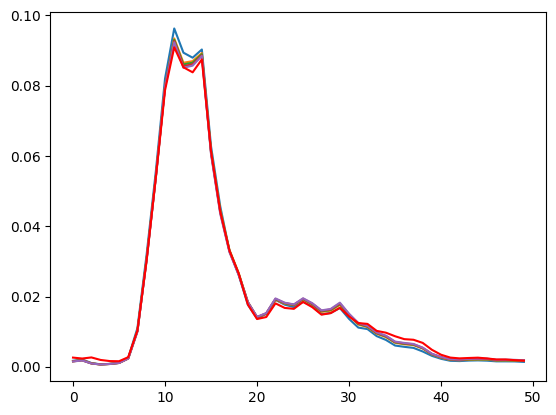

In [3]:
DicConfigYaml = { 
    'ART_VitalDB' : {'SKZFC_ART_1_30_800_VitalDB':   './Config/EvalConfigVitalDB.yml',              
                     'VDWave_ART_VitalDB':   './Benchmarks/Config/EvalConfigART_Other.yml', 
                     'VDVAE_ART_30_VitalDB':   './Benchmarks/Config/EvalConfigART_VAE.yml'},
   
    'ART_Mimic' : {'SKZFC_ART_1_30_800_Mimic':   './Config/EvalConfigMimic.yml',              
                     'VDWave_ART_Mimic':   './Benchmarks/Config/EvalConfigART_Other.yml', 
                     'VDVAE_ART_30_Mimic':   './Benchmarks/Config/EvalConfigART_VAE.yml'},
    
    'II_VitalDB' : {'SKZFC_II_1_30_800_VitalDB':   './Config/EvalConfigVitalDB.yml',              
                     'VDWave_II_VitalDB':   './Benchmarks/Config/EvalConfigII_Other.yml', 
                     'VDVAE_II_30_VitalDB':   './Benchmarks/Config/EvalConfigII_VAE.yml'},
    
    'II_Mimic' : {'SKZFC_II_1_30_800_Mimic':   './Config/EvalConfigMimic.yml',              
                     'VDWave_II_Mimic':   './Benchmarks/Config/EvalConfigII_Other.yml', 
                     'VDVAE_II_30_Mimic':   './Benchmarks/Config/EvalConfigII_VAE.yml'}    }



# Define frequency control ranges for the SKZ branch
FC_RANGES = [[0, 0.2], [0.2, 0.4], [0.4, 0.6], [0.6, 0.8], [0.8, 1.0]]

DicPList = copy.deepcopy(DicConfigYaml)
DicQ = copy.deepcopy(DicConfigYaml)

for UpKey in DicConfigYaml.keys():
    for DnKey in DicConfigYaml[UpKey]:
        EvalConfigs = ReadYaml(DicConfigYaml[UpKey][DnKey])
        print(DnKey, DicConfigYaml[UpKey][DnKey])
        if 'SKZ' in DnKey:
            ModelConfigSet, ModelLoadName = LoadModelConfigs(DnKey)
        else:
            ModelConfigSet, ModelLoadName = LoadModelConfigs(DnKey, Comp=False, TypeDesig=True, RootDirYaml='./Benchmarks/Config/', RootDirRes=None)

        if 'SKZ' in DnKey:
            # Loading parameters for the evaluation
            Params = LoadParams(ModelConfigSet, EvalConfigs['Parameters'])
            Params['Common_Info'] = EvalConfigs['Common_Info']
        else:
            CommonParams = EvalConfigs['Common_Param']
            ModelParams = EvalConfigs["Models"][DnKey]
            Params = LoadParams(ModelConfigSet, {**CommonParams, **ModelParams})
            Params['Common_Info'] = EvalConfigs['Common_Info']


        # Loading data
        AnalData = np.load('./Data/ProcessedData/'+str(Params['TestDataSource'])+'Test'+str(Params['SigType'])+'.npy').astype('float64')[:Params['EvalDataSize']]
        
        # Intermediate parameters 
        SigDim = AnalData.shape[1]
        Params['DataSize'] = Params['EvalDataSize']

        
        if 'SKZ' in DnKey: 
            # Calling Modesl
            SigRepModel, ModelParts = ModelCall (ModelConfigSet, SigDim, Params['DataSize'], LoadWeight=True, ReturnModelPart=True, 
                                                 ReparaStd=Params['ReparaStd'], ModelSaveName=ModelLoadName, Reparam=False)

            # Setting Model Specifications and Sub-models
            if Params['LossType'] =='Default':
                EncModel, FeatExtModel, FeatGenModel, ReconModel = ModelParts
            elif Params['LossType'] =='FACLosses':
                EncModel, FeatExtModel, FeatGenModel, ReconModel, FacDiscModel = ModelParts
            
            
            ## The generation model for evaluation
            RecOut = ReconModel(FeatGenModel.output)
            GenModel = Model(FeatGenModel.input, RecOut)
            Encoder = Model(SigRepModel.get_layer('Inp_Enc').input, [SigRepModel.get_layer('Zs').output, SigRepModel.get_layer('FCs').output])

            resP, Q = process_SKZ(AnalData, Params, GenModel, Encoder, FC_RANGES)
            
        elif 'VAE' in DnKey:
            TrData = np.load('./Data/ProcessedData/'+str(Params['DataSource'])+'Tr'+str(Params['SigType'])+'.npy').astype('float64')
            BenchModel, _, AnalData = BMCaller (Params, DnKey, TrData, AnalData, LoadWeight=True, Reparam=False, 
                                                ReparaStd=Params['ReparaStd'], ModelSaveName='./Benchmarks/' + ModelLoadName[2:])

            ## The generation model for evaluation
            GenModel = BenchModel.get_layer('ReconModel')

            ## The sampling model for evaluation
            Inp_Enc = BenchModel.get_layer('Inp_Enc')
            
            if 'VDV' in DnKey:
                Zs = tf.concat([BenchModel.get_layer('Zs'+str(i)).output for i in range(len(Params['LatDim']))], axis=-1)
            else:
                Zs = BenchModel.get_layer('Zs').output
            Inp_Cond = BenchModel.get_layer('Inp_Cond')
            SampZModel = Model([Inp_Enc.input, Inp_Cond.input], Zs)

            resP, Q = process_VAE(AnalData, Params, GenModel, SampZModel)

        elif 'DiffWave' in DnKey or 'VDWave' in DnKey:
            TrData = np.load('./Data/ProcessedData/'+str(Params['DataSource'])+'Tr'+str(Params['SigType'])+'.npy').astype('float64')
            SigMax = np.load('./Data/ProcessedData/'+str(Params['DataSource'])+'SigMax.pkl', allow_pickle=True)
            SigMin = np.load('./Data/ProcessedData/'+str(Params['DataSource'])+'SigMin.pkl', allow_pickle=True)
            
            TrDeNorm = (TrData * (SigMax[Params['SigType']] - SigMin[Params['SigType']]) + SigMin[Params['SigType']]).copy()
            ValDeNorm = (AnalData * (SigMax[Params['SigType']] - SigMin[Params['SigType']]) + SigMin[Params['SigType']]).copy()
            
            MeanSig, SigmaSig = np.mean(TrDeNorm), np.std(TrDeNorm) 
            TrInp = (TrDeNorm-MeanSig)/SigmaSig
            ValInp = (ValDeNorm-MeanSig)/SigmaSig

            GenModel, _, AnalData = BMCaller (Params, DnKey, TrInp, ValInp, LoadWeight = True, ModelSaveName='./Benchmarks/' + ModelLoadName[2:])      

            if 'DiffWave' in DnKey:
                resP, Q = process_DiffWave(AnalData, Params, GenModel, SigmaSig, MeanSig, SigMin, SigMax)
            elif 'VDWave' in DnKey:
                resP, Q = process_VDWave(AnalData, Params, GenModel, SigmaSig, MeanSig, SigMin, SigMax)

        DicPList[UpKey][DnKey] = resP 
        DicQ[UpKey][DnKey] = Q


# Save to file
with open("./EvalResults/Instances/DicPList.pkl", "wb") as f:
    pickle.dump(DicPList, f)

with open("./EvalResults/Instances/DicQ.pkl", "wb") as f:
    pickle.dump(DicQ, f)


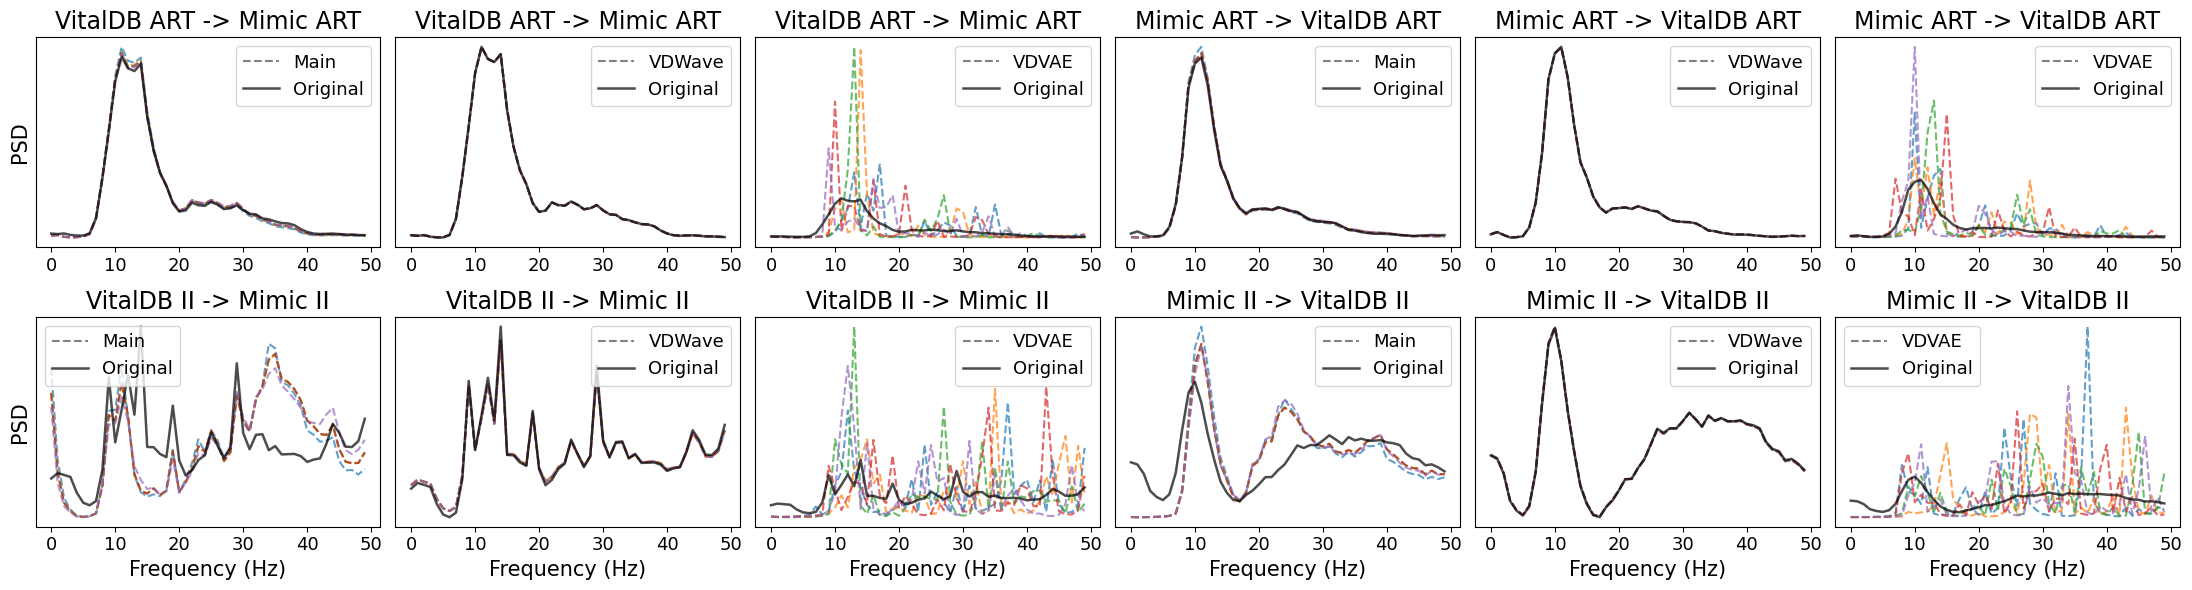

In [3]:
with open("./EvalResults/Instances/DicPList.pkl", "rb") as f:
    DicPList = pickle.load(f)

with open("./EvalResults/Instances/DicQ.pkl", "rb") as f:
    DicQ = pickle.load(f)

# Font size settings 
FONT_SIZE = 15      # For axis labels and tick labels 
TITLE_SIZE = 17     # For subplot titles 
LEGEND_SIZE = 13    # For legend text 
YTICK_SIZE = 12      # New setting for y-tick label size (smaller than default)

# Set to True to hide y-axis ticks and labels completely
HIDE_YTICKS = True  # Can be changed to True if needed

# Spacing parameters - can be adjusted as needed
HSPACE = 0.4  # Height space between subplots
WSPACE = 0.3  # Width space between subplots
 
# Keys to iterate (each key format: "SignalType_DataSource") 
up_keys = ['ART_VitalDB', 'ART_Mimic', 'II_VitalDB', 'II_Mimic'] 
 
# Function to map model abbreviation from dn_key 
def get_model_label(dn_key): 
    if 'SKZFC' in dn_key: 
        return 'Main' 
    elif 'VDWave' in dn_key: 
        return 'VDWave' 
    elif 'TCVAE' in dn_key: 
        return 'TC-VAE' 
    elif 'VDVAE' in dn_key: 
        return 'VD-VAE' 
    else: 
        return dn_key  # fallback: use original 
 
# Create subplots (2 rows x 6 columns) 
fig, axes = plt.subplots(2, 6, figsize=(22, 6)) 

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=HSPACE, wspace=WSPACE)

subplot_index = 0 
 
for up_key in up_keys: 
    # Split up_key into signal type and data source 
    signal_type, data_source = up_key.split('_') 
     
    # Determine target: if current data source is 'VitalDB', then target becomes 'Mimic', 
    # and vice versa if data source is 'Mimic' 
    if data_source == "VitalDB": 
        target = "Mimic" 
    elif data_source == "Mimic": 
        target = "VitalDB" 
    else: 
        target = "" 
     
    for dn_key in DicPList[up_key]: 
        row_idx = subplot_index // 6 
        col_idx = subplot_index % 6 
        ax = axes[row_idx, col_idx] 
 
        # Plot generated signals with dashed lines (using various colors automatically) 
        for vec in DicPList[up_key][dn_key]: 
            ax.plot(np.squeeze(vec), linestyle='--', alpha=0.7) 
         
        # Plot the reference/original signal in solid black and capture its handle 
        original_handle, = ax.plot(DicQ[up_key][dn_key], color='black', linewidth=1.8, label='Original', alpha=0.7) 
         
        # Create a dummy line for the legend using the model abbreviation from dn_key 
        model_label = get_model_label(dn_key) 
        model_legend_line = mlines.Line2D([], [], color='gray', linestyle='--', label=model_label) 
 
        # Set subplot title in the format: "Source -> Target SignalType" 
        title = f"{data_source} {signal_type} -> {target} {signal_type}" 
        ax.set_title(title, fontsize=TITLE_SIZE) 
 
        # Set x-label only for subplots in the bottom row 
        if row_idx == 1: 
            ax.set_xlabel("Frequency (Hz)", fontsize=FONT_SIZE) 
        # Set y-label only for subplots in the first column 
        if col_idx == 0: 
            ax.set_ylabel("PSD", fontsize=FONT_SIZE) 
 
        # Handle Y-axis ticks and labels based on settings
        if HIDE_YTICKS:
            ax.set_yticks([])  # Remove y-ticks completely
            ax.set_yticklabels([])  # Remove y-tick labels
        else:
            ax.tick_params(axis='y', labelsize=YTICK_SIZE)  # Reduce y-tick label size
            
        # Set x-tick parameters
        ax.tick_params(axis='x', labelsize=FONT_SIZE - 2) 
         
        # Set legend with the dummy model handle and the original signal handle 
        ax.legend(handles=[model_legend_line, original_handle], fontsize=LEGEND_SIZE) 
 
        subplot_index += 1 
 
plt.tight_layout() 
plt.show()

Saved GenDist VitalDB to Mimic.png


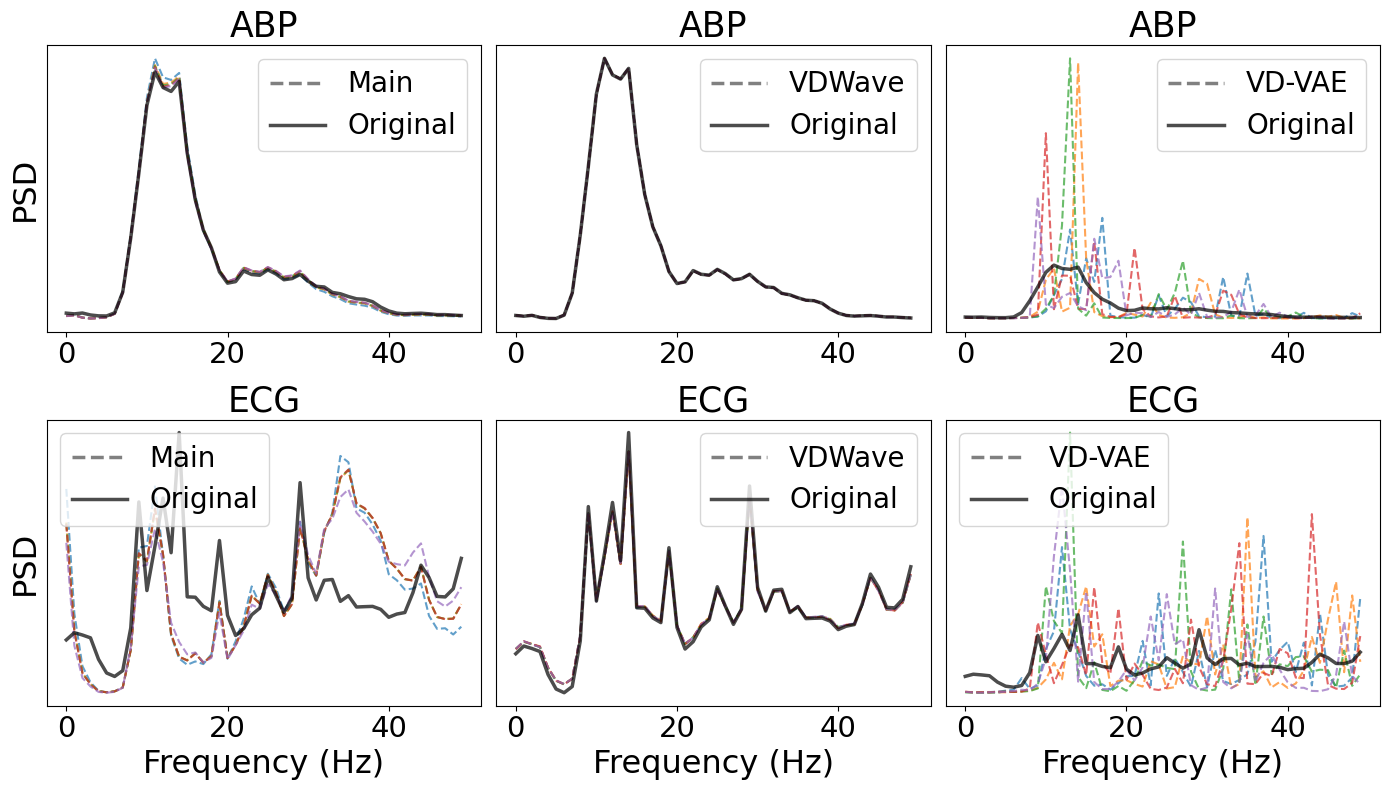

Saved GenDist Mimic to VitalDB.png


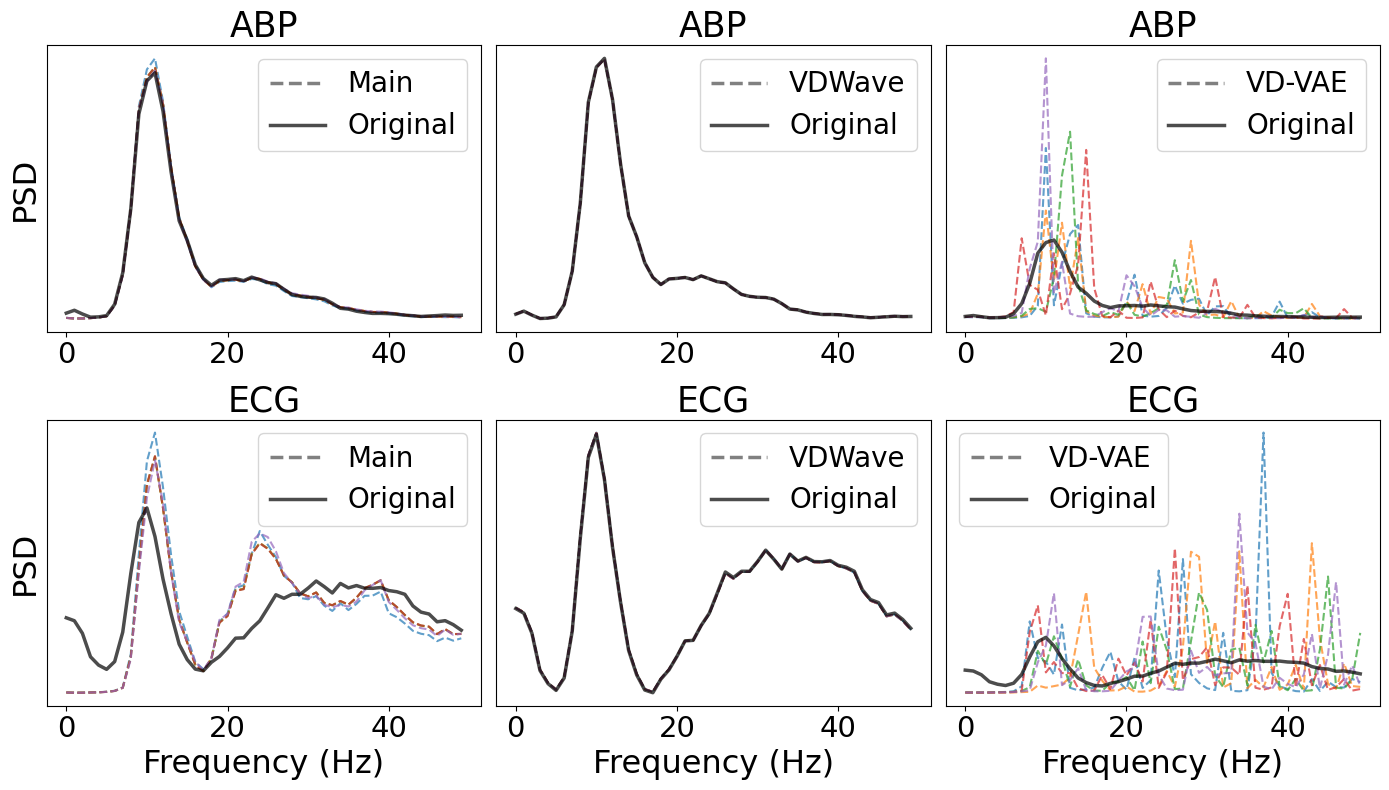

In [4]:
# --- Data loading and basic setup ---
with open("./EvalResults/Instances/DicPList.pkl", "rb") as f:
    DicPList = pickle.load(f)
with open("./EvalResults/Instances/DicQ.pkl", "rb") as f:
    DicQ = pickle.load(f)

FONT_SIZE = 23      # Font size for axis labels and tick labels
TITLE_SIZE = 25     # Font size for subplot titles
LEGEND_SIZE = 20    # Font size for legend text
YTICK_SIZE = 20     # Font size for y-tick labels (if shown)
HIDE_YTICKS = True  # Whether to hide y-axis ticks and labels
HSPACE = 0.4        # Vertical space between subplots
WSPACE = 0.3        # Horizontal space between subplots

up_keys = ['ART_VitalDB', 'ART_Mimic', 'II_VitalDB', 'II_Mimic']

def get_model_label(dn_key):
    if 'SKZFC' in dn_key:
        return 'Main'
    elif 'VDWave' in dn_key:
        return 'VDWave'
    elif 'TCVAE' in dn_key:
        return 'TC-VAE'
    elif 'VDVAE' in dn_key:
        return 'VD-VAE'
    else:
        return dn_key  # Fallback: use original key

# --- (1) Collect all (up_key, dn_key) pairs grouped by source ---
groups = {'VitalDB': [], 'Mimic': []}
for up_key in up_keys:
    _, data_source = up_key.split('_')
    for dn_key in DicPList[up_key]:
        groups[data_source].append((up_key, dn_key))

# --- (2) For each source, plot a 2×3 figure and save/display ---
for source, chunk in groups.items():
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    plt.subplots_adjust(hspace=HSPACE, wspace=WSPACE)

    for i, (up_key, dn_key) in enumerate(chunk):
        row, col = divmod(i, 3)
        ax = axes[row, col]

        signal_type, _ = up_key.split('_')
        signal_type = 'ABP' if signal_type == 'ART' else 'ECG' if signal_type == 'II' else signal_type
        target = 'Mimic' if source == 'VitalDB' else 'VitalDB'

        # Plot generated signals (dashed lines)
        for vec in DicPList[up_key][dn_key]:
            ax.plot(np.squeeze(vec), linestyle='--', alpha=0.7)

        # Plot the reference signal (solid black line)
        original_handle, = ax.plot(
            DicQ[up_key][dn_key],
            color='black',
            linewidth=2.5,
            label='Original',
            alpha=0.7
        )

        # Dummy line for the model legend with thicker linewidth
        model_label = get_model_label(dn_key)
        dummy_line = mlines.Line2D(
            [], [], color='gray', linestyle='--',
            linewidth=2.5, label=model_label
        )

        # Title and axis labels
        ax.set_title(f"{signal_type}", fontsize=TITLE_SIZE)
        if row == 1:
            ax.set_xlabel("Frequency (Hz)", fontsize=FONT_SIZE)
        if col == 0:
            ax.set_ylabel("PSD", fontsize=FONT_SIZE)

        # Y-axis ticks
        if HIDE_YTICKS:
            ax.set_yticks([])
            ax.set_yticklabels([])
        else:
            ax.tick_params(axis='y', labelsize=YTICK_SIZE)
        ax.tick_params(axis='x', labelsize=FONT_SIZE - 2)

        # Legend
        ax.legend(handles=[dummy_line, original_handle], fontsize=LEGEND_SIZE)

    # Remove any unused subplots
    total_plots = len(chunk)
    for j in range(total_plots, 6):
        r, c = divmod(j, 3)
        fig.delaxes(axes[r, c])

    plt.tight_layout()

    # Save to file
    filename = f"GenDist {source} to {target}.png"
    fig.savefig('./PaperWork/Figures/'+filename, dpi=300, bbox_inches='tight')
    print(f"Saved {filename}")

    # Display inline in the notebook
    plt.show()
    plt.close(fig)
